## Semantic text search using Azure OpenAI embeddings

We can search through all our reviews semantically in a very efficient manner and at very low cost, by simply embedding our search query, and then finding the most similar reviews. 

In [1]:
import os
import sys
os.path.dirname(sys.executable)


'c:\\Python\\Python311'

In [2]:
import os
import sys
os.path.dirname(sys.executable)


'C:\\Users\\rolester\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0'

In [2]:
#pip install openai num2words matplotlib plotly scipy scikit-learn transformers
#!pip install --upgrade openai
#!pip install --upgrade NumPy==1.24.0
#!pip install --upgrade numpy==1.22.4
#!pip install --upgrade numpy



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\rolester\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import os
import openai
import pandas as pd
import numpy as np
import re
import requests
import sys
from openai.embeddings_utils import get_embedding, cosine_similarity


In [4]:
openai.api_type = "azure"
openai.api_base = "https://southcentralOpenAIral.openai.azure.com/"
openai.api_version = "2022-12-01"
openai.api_key = open("AzurekeySCUS.txt","r").read()


In [27]:
# Function to read paragraphs from the text file
def read_paragraphs(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        paragraphs = content.split('\n\n')
    return paragraphs

file_path = 'C:\\R\\Alice.txt' #27,000 words
paragraphs = read_paragraphs(file_path)

paragraphs_df = pd.DataFrame({'paragraph': paragraphs})

paragraphs_df['paragraph'].count()


827

In [34]:
paragraphs_df = paragraphs_df[paragraphs_df["paragraph"] != ''] #Remove black strings

In [35]:
paragraphs_df['embedding'] = paragraphs_df["paragraph"].apply(lambda x : get_embedding(x, engine = 'textembeddingada002v2'))
#4 mins v1
#3 mins v2

#https://learn.microsoft.com/en-us/azure/cognitive-services/openai/how-to/integrate-synapseml


In [56]:
paragraphs_df.head()

,embedding
0,"[-0.0009895042749121785, -0.003143131267279386..."
1,"[-0.005550594534724951, -0.002100438578054309,..."
2,"[-0.016373122110962868, -0.00787348672747612, ..."
3,"[-0.013116865418851376, -0.009315624833106995,..."
4,"[0.0011981818825006485, -0.009525999426841736,..."
...,...
822,"[0.0009866133332252502, -0.007847321219742298,..."
823,"[-0.01608996093273163, -0.008282762952148914, ..."
824,"[0.002863217843696475, -0.006862502545118332, ..."
825,"[0.017221204936504364, -0.004995867609977722, ..."


### Normalize text ###

### Calculate embedding for review summary and review text and save it to local file ###

In [6]:
paragraphs_df.to_csv('data/Alice_with_embeddings.csv')

### Load pre-calculated embedding from file ###

In [5]:
datafile_path = "data/Alice_with_embeddings.csv"
df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)
df.head(5)

,Unnamed: 0,paragraph,embedding
0,0,CHAPTER I. Down the Rabbit-Hole,"[-0.0009895042749121785, -0.003143131267279386..."
1,1,Alice was beginning to get very tired of sitti...,"[-0.005550594534724951, -0.002100438578054309,..."
2,2,So she was considering in her own mind (as wel...,"[-0.016373122110962868, -0.00787348672747612, ..."
3,3,There was nothing so VERY remarkable in that; ...,"[-0.013116865418851376, -0.009315624833106995,..."
4,4,"In another moment down went Alice after it, ne...","[0.0011981818825006485, -0.009525999426841736,..."


### Function to compare the cosine similarity of the query and reviews and show top_n best matches. ###

In [6]:

# search through the reviews for a specific product using natural language text
def search_reviews(df, query, n=3, pprint=True):
    
    query_embedding = get_embedding(query,engine="textembeddingada002v2")
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, query_embedding)) #not a call to the webservice

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .paragraph.str.replace("Summary: ", "")
        .str.replace("; Text:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:600])
            print()
    return results


In [7]:
results = search_reviews(df, "I like the red queen and cats?", n=4)

'How do you like the Queen?' said the Cat in a low voice.

'A cat may look at a king,' said Alice. 'I've read that in some book,
but I don't remember where.'

Alice replied eagerly, for she was always ready to talk about her pet:
'Dinah's our cat. And she's such a capital one for catching mice you
can't think! And oh, I wish you could see her after the birds! Why,
she'll eat a little bird as soon as look at it!'

'Call it what you like,' said the Cat. 'Do you play croquet with the
Queen to-day?'



In [31]:
results = search_reviews(df, "Is the cat nice?", n=3)

The Cat only grinned when it saw Alice. It looked good-natured, she
thought: still it had VERY long claws and a great many teeth, so she
felt that it ought to be treated with respect.

'How do you like the Queen?' said the Cat in a low voice.

'How are you getting on?' said the Cat, as soon as there was mouth
enough for it to speak with.



In [32]:
strPrompt = """The Cat only grinned when it saw Alice. It looked good-natured, she
thought: still it had VERY long claws and a great many teeth, so she
felt that it ought to be treated with respect.

'How do you like the Queen?' said the Cat in a low voice.

'How are you getting on?' said the Cat, as soon as there was mouth
enough for it to speak with.

Is the cat nice?

Dont make anythign up.

Only use the data

"""
response = openai.Completion.create(
    engine="textdavinci003",
    prompt=strPrompt,
    temperature=0.2, #temperatue 0-1: 0 same answers 1 different answers 
    max_tokens=600,
    frequency_penalty=0.0,
    presence_penalty=0.0
)
#  top_p=1.0,

text = response['choices'][0]['text'].replace(' .', '.').strip()
print(text)

It is difficult to say whether the cat is nice or not based on the given data. The cat is described as looking good-natured and Alice felt it should be treated with respect. The cat also has long claws and many teeth, which could be interpreted as a sign of aggression.


In [33]:
results = search_reviews(df, "Is the red queen a bad person?", n=1)

Alice thought she might as well go back, and see how the game was going
on, as she heard the Queen's voice in the distance, screaming with
passion. She had already heard her sentence three of the players to be
executed for having missed their turns, and she did not like the look
of things at all, as the game was in such confusion that she never knew
whether it was her turn or not. So she went in search of her hedgehog.



In [34]:
strPrompt = """Alice thought she might as well go back, and see how the game was going
on, as she heard the Queen's voice in the distance, screaming with
passion. She had already heard her sentence three of the players to be
executed for having missed their turns, and she did not like the look
of things at all, as the game was in such confusion that she never knew
whether it was her turn or not. So she went in search of her hedgehog.

Is the red queen a bad person?
"""
response = openai.Completion.create(
    engine="textdavinci003",
    prompt=strPrompt,
    temperature=0.2, #temperatue 0-1: 0 same answers 1 different answers 
    max_tokens=600,
    frequency_penalty=0.0,
    presence_penalty=0.0
)
#  top_p=1.0,

text = response['choices'][0]['text'].replace(' .', '.').strip()
print(text)

The Red Queen is not necessarily a bad person, but she is a powerful figure who is willing to take drastic measures to maintain order and control. She is also known for her temper and her tendency to be unforgiving.


In [148]:

strPrompt = """Of the following paragraphs from a book what food is there nad also what drink? Show as a list

'What did they live on?' said Alice, who always took a great interest in
questions of eating and drinking.

The great question certainly was, what? Alice looked all round her at
the flowers and the blades of grass, but she did not see anything that
looked like the right thing to eat or drink under the circumstances.
There was a large mushroom growing near her, about the same height as
herself; and when she had looked under it, and on both sides of it, and
behind it, it occurred to her that she might as well look and see what
was on the top of it.

Soon her eye fell on a little glass box that was lying under the table:
she opened it, and found in it a very small cake, on which the words
'EAT ME' were beautifully marked in currants. 'Well, I'll eat it,' said
Alice, 'and if it makes me grow larger, I can reach the key; and if it
makes me grow smaller, I can creep under the door; so either way I'll
get into the garden, and I don't care which happens!'

However, this bottle was NOT marked 'poison,' so Alice ventured to taste
it, and finding it very nice, (it had, in fact, a sort of mixed flavour
of cherry-tart, custard, pine-apple, roast turkey, toffee, and hot
buttered toast,) she very soon finished it off.

"""

response = openai.Completion.create(
    engine="textdavinci003",
    prompt=strPrompt,
    temperature=0.2, #temperatue 0-1: 0 same answers 1 different answers 
    max_tokens=1600,
    frequency_penalty=0.0,
    presence_penalty=0.0
)
#  top_p=1.0,

text = response['choices'][0]['text'].replace(' .', '.').strip()
print(text)


Food: 
- Cake 
- Cherry-tart 
- Custard 
- Pine-apple 
- Roast turkey 
- Toffee 
- Hot buttered toast

Drink: 
- Bottle


### Visualize embeddings

In [33]:
import pandas as pd
samples = pd.read_json("data/dbpedia_samples.jsonl", lines=True)
categories = sorted(samples["category"].unique())
#print("Categories of DBpedia samples:", samples["category"].value_counts())
samples.head()

,text,category
0,Morada Limited is a textile company based in ...,Company
1,The Armenian Mirror-Spectator is a newspaper ...,WrittenWork
2,Mt. Kinka (金華山 Kinka-zan) also known as Kinka...,NaturalPlace
3,Planning the Play of a Bridge Hand is a book ...,WrittenWork
4,Wang Yuanping (born 8 December 1976) is a ret...,Athlete


In [34]:
from openai.embeddings_utils import get_embeddings
openai.api_type = "azure"
openai.api_base = "https://southcentralOpenAIral.openai.azure.com/"
openai.api_version = "2022-12-01"
openai.api_key = open("AzurekeySCUS.txt","r").read()

url = openai.api_base + "/openai/deployments?api-version=2022-12-01"

matrix = samples["text"].apply(lambda x : get_embedding(x, engine = 'textembeddingada002v2'))

from sklearn.decomposition import PCA
matrix = matrix.to_list()
pca = PCA(n_components=3)
vis_dims = pca.fit_transform(matrix)
samples["embed_vis"] = vis_dims.tolist()


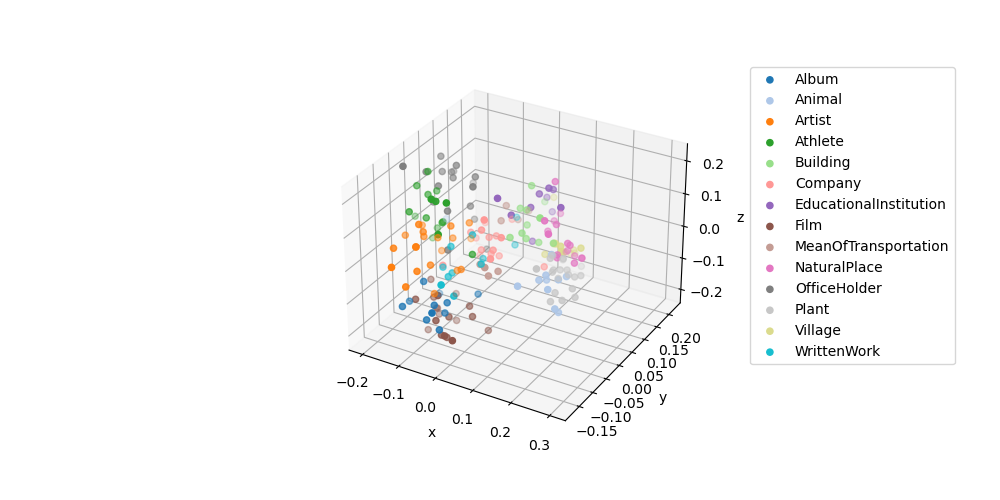

In [35]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap("tab20")

# Plot each sample category individually such that we can set label name.
for i, cat in enumerate(categories):
    sub_matrix = np.array(samples[samples["category"] == cat]["embed_vis"].to_list())
    x=sub_matrix[:, 0]
    y=sub_matrix[:, 1]
    z=sub_matrix[:, 2]
    colors = [cmap(i/len(categories))] * len(sub_matrix)
    ax.scatter(x, y, zs=z, zdir='z', c=colors, label=cat)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(bbox_to_anchor=(1.1, 1))

## END ##